In [1]:
import torchvision
import os
import io
from torchvision import transforms
from transformers import ViTModel
from transformers import ViTFeatureExtractor
import numpy as np

In [4]:
os.chdir("/Users/user/Downloads/Salmon")

In [5]:
os.listdir()

['Wild', 'Farm']

### Farmed will be encoded as 0, wild as 1

In [3]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

/Users/user/opt/anaconda3/envs/data/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [21]:
train_ds= torchvision.datasets.ImageFolder('/Users/user/Downloads/Salmon/Train', transform=transform)
test_ds = torchvision.datasets.ImageFolder('/Users/user/Downloads/Salmon/Test', transform=transform)

In [23]:
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=2):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
            return logits, loss.item()
        else:
            return logits, None

In [24]:
EPOCHS = 5
BATCH_SIZE = 20
LEARNING_RATE = 1e-4

In [25]:
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

In [26]:
import torch.utils.data as data
from torch.autograd import Variable


print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=1)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=1) 

Number of train samples:  340
Number of test samples:  80
Detected Classes are:  {'Farm': 0, 'Wild': 1}


In [27]:
# Train the model
for epoch in range(EPOCHS):        
    for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
        x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
        x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
    # Send to GPU if available
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)   # batch x (image)
    b_y = Variable(y)   # batch y (target)
    # Feed through model
    output, loss = model(b_x, None)
    # Calculate loss
    if loss is None: 
        loss = loss_func(output, b_y)   
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()
    print(epoch)
    print(step)
    
        # Get the next batch for testing purposes
    test = next(iter(test_loader))
    test_x = test[0]
        # Reshape and get feature matrices as needed
    test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
    for index, array in enumerate(test_x):
        test_x[index] = np.squeeze(array)
    test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
        # Send to appropirate computing device
    test_x = test_x.to(device)
    test_y = test[1].to(device)
        # Get output (+ respective class) and compare to target
    test_output, loss = model(test_x, test_y)
    test_output = test_output.argmax(1)
        # Calculate Accuracy
    accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
    print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

0
16
Epoch:  0 | train loss: 0.6851 | test accuracy: 0.60
1
16
Epoch:  1 | train loss: 0.6325 | test accuracy: 0.70
2
16
Epoch:  2 | train loss: 0.5924 | test accuracy: 0.85
3
16
Epoch:  3 | train loss: 0.5980 | test accuracy: 0.85
4
16
Epoch:  4 | train loss: 0.5631 | test accuracy: 0.85


In [20]:
#use to this load model in flask script
torch.save(model.state_dict(), '/Users/user/Downloads/model_dict.pt')

In [21]:
#full serialized model
torch.save(model,'/Users/user/Downloads/model_cpu.pt')

In [4]:
import torch
MODEL_PATH = '/Users/user/Downloads/model_cpu.pt'
model = torch.load(MODEL_PATH)

In [23]:
EVAL_BATCH = 1
valid_ds = torchvision.datasets.ImageFolder('/Users/user/Downloads/Salmon/Validation', transform=transform)
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=1) 

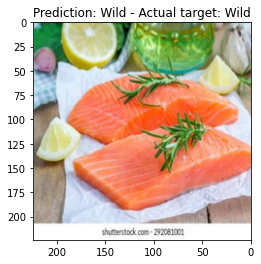

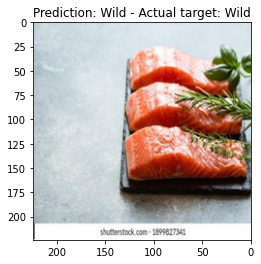

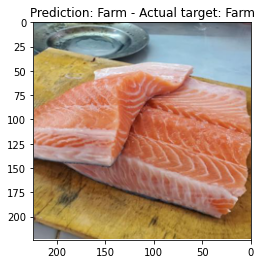

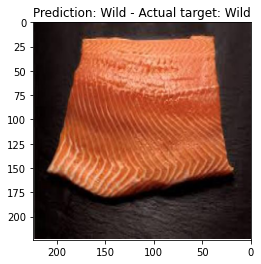

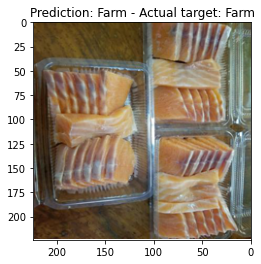

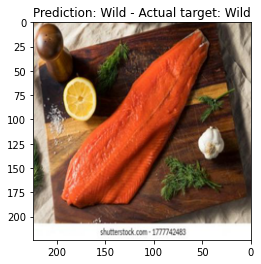

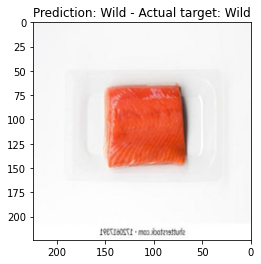

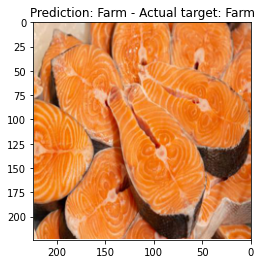

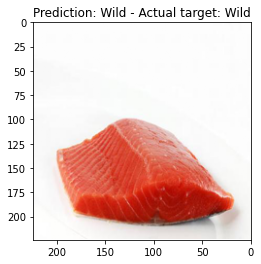

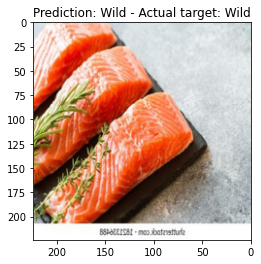

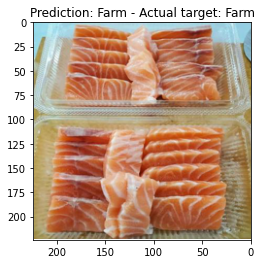

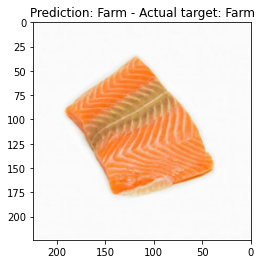

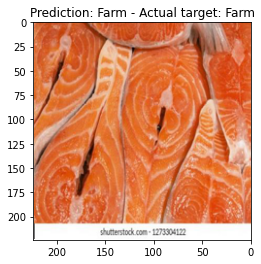

In [24]:
import matplotlib.pyplot as plt
# Disable grad
with torch.no_grad():
    # with multiple validation images with batch size 1, we need to use enumerate(trainloader)
    # step - number of batches
    # x - image tensor, y - labels
    for step , (x, y) in enumerate(eval_loader):
        picture  = x[0].permute(1, 2, 0)
        x = np.split(np.squeeze(np.array(x)), EVAL_BATCH)
        # Reshape and get feature matrices as needed
        for index, array in enumerate(x):
            x[index] = np.squeeze(array)
        # Apply feature extractor, stack back into 1 tensor and then convert to tensor
        x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
        # Send to GPU if available
        x, y  = x.to(device), y.to(device)

        # Generate prediction
        prediction, loss = model(x, y)

        # Predicted class value using argmax
        predicted_class = np.argmax(prediction)
        value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
        value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(y)]

        # Show result
        plt.imshow(picture)
        plt.xlim(224,0)
        plt.ylim(224,0)
        plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
        plt.show()